In [1]:
# Cellular Automata and Complexity
# ---------------------------------
# Author: [Your Name]
# Course: Model-Based Decisions in Complex Systems
# Week 1 — Complexity and Emergence
# ---------------------------------

import numpy as np
import matplotlib.pyplot as plt
from math import log2
from itertools import product
from sklearn.metrics import mutual_info_score
import pandas as pd

plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['image.cmap'] = 'binary'

In [2]:
def rule_to_array(rule_number):
    """Convert integer rule number (0–255) to binary array of length 8."""
    #The first element in the array corresponds to the neighborhood state 111, 
    # the second element to 110, and so on (decreasing binary number)
    # rule_array[0] -> 111 (7)
    # rule_array[1] -> 110 (6)
    # rule_array[2] -> 101 (5)
    # rule_array[3] -> 100 (4)
    # rule_array[4] -> 011 (3)
    # rule_array[5] -> 010 (2)
    # rule_array[6] -> 001 (1)
    # rule_array[7] -> 000 (0)
    # so rule 30 will give the array [0, 0, 0, 1, 1, 1, 1, 0] which is 30 in binary
    rule_array = np.array([int(x) for x in np.binary_repr(rule_number, width=8)], dtype=np.uint8)
    return rule_array

def evolve_ca(rule_number, n_cells=101, n_steps=100, seed=None):
    """Run 1D cellular automaton."""
    rule = rule_to_array(rule_number)
    cells = np.zeros((n_steps, n_cells), dtype=np.uint8)

    # Initialize
    if seed is None:
        cells[0, n_cells//2] = 1
    else:
        np.random.seed(seed)
        cells[0] = np.random.randint(0, 2, n_cells)

    # Neighborhood states (binary pattern -> index)
    for t in range(1, n_steps):
        left = np.roll(cells[t-1], 1) #gets left neighbour (periodic boundary)
        center = cells[t-1] #ce
        right = np.roll(cells[t-1], -1)
        pattern = (left << 2) | (center << 1) | right
        cells[t] = rule[7 - pattern]  # reversed order for rule definition
    return cells

In [3]:
def plot_ca(cells, title=""):
    plt.imshow(cells, interpolation='nearest', aspect='auto')
    plt.title(title)
    plt.xlabel('Cell')
    plt.ylabel('Time step')
    plt.show()

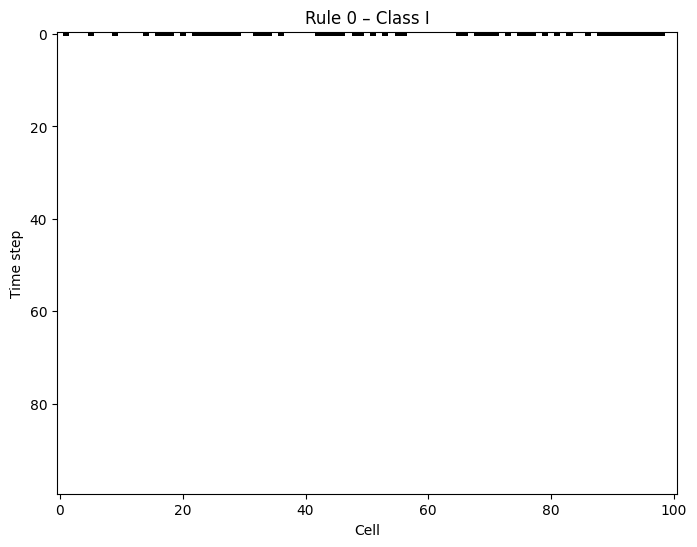

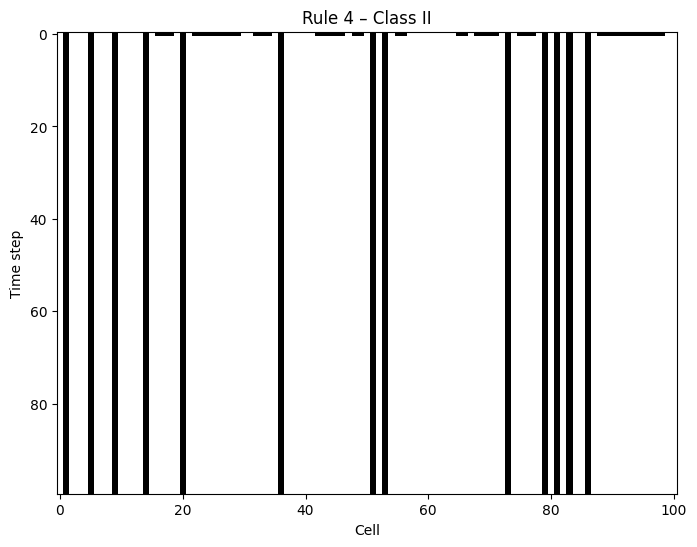

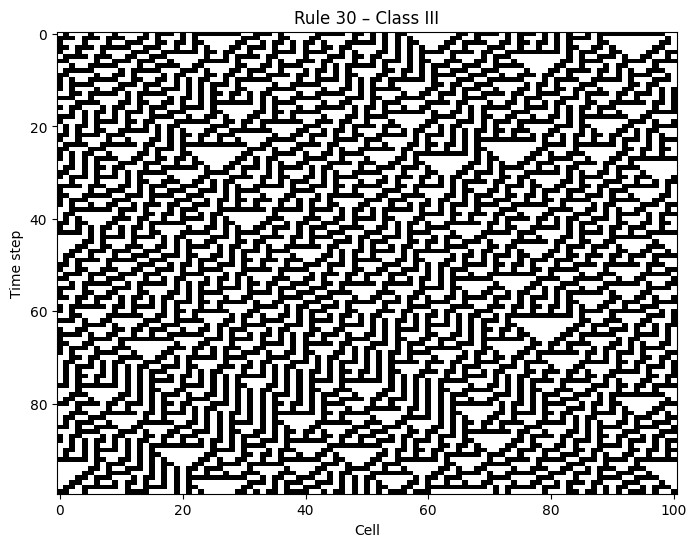

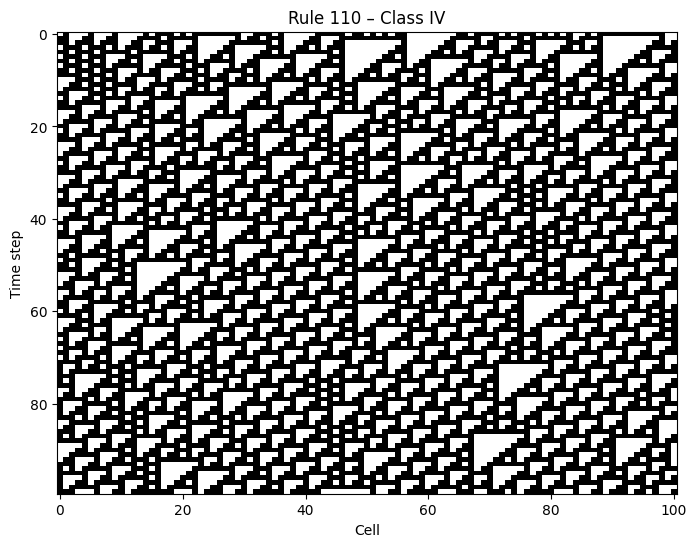

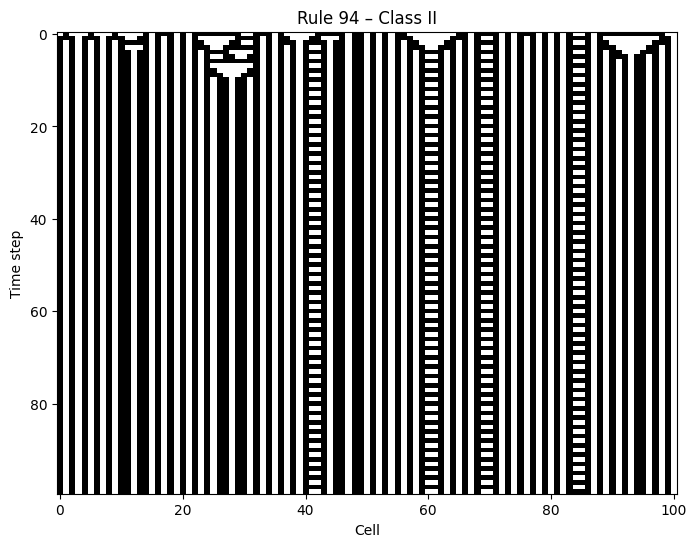

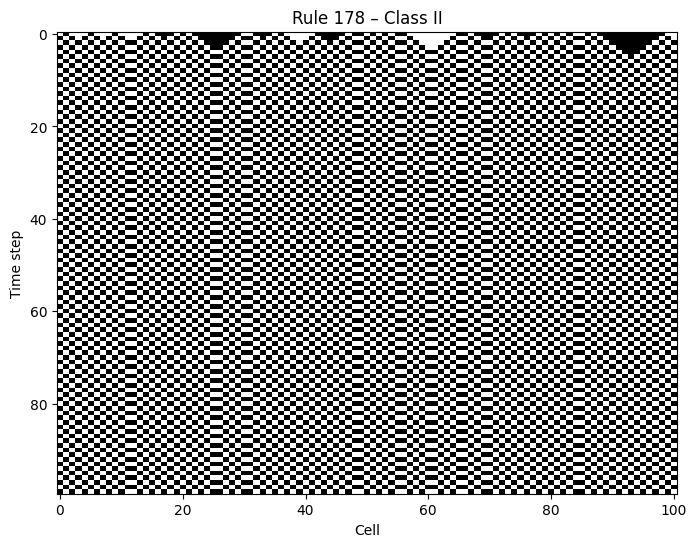

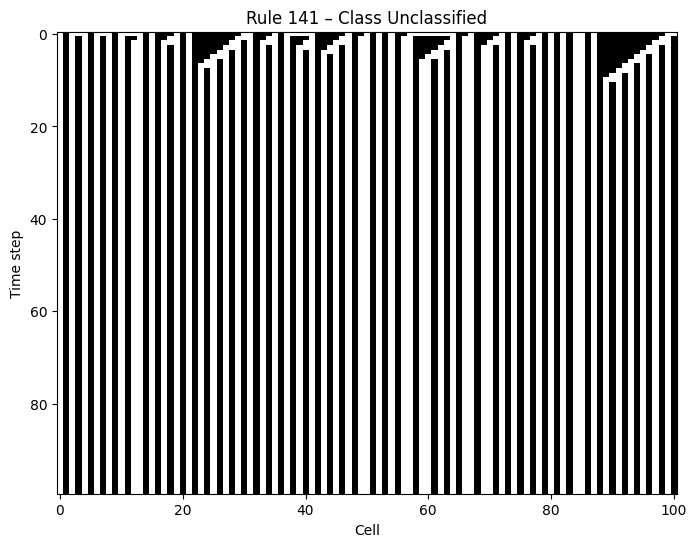

In [4]:
# --- Wolfram class mapping ---
wolfram_classes = {
    "I":  [0, 8, 32, 40, 128, 136, 160, 168],
    "II": [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 19, 23, 24, 25, 26, 27, 28, 29, 33, 34, 35, 36, 37, 38, 42, 43, 44, 46, 50, 51, 56, 57, 58, 62, 72, 73, 74, 76, 77, 78, 94, 104, 108, 130, 132, 134, 138, 140, 142, 152, 154, 156, 162, 164, 170, 172, 178, 184, 200, 204, 232],
    "III":[18, 22, 30, 45, 60, 73, 90, 105, 106, 122, 126, 129, 135, 146, 149, 150, 151, 153, 161, 165, 169, 225],
    "IV": [41, 54, 110, 124, 137, 193]
}

# --- Automatically build list of rules with class labels ---
rules_to_run = []
for cls, rules in wolfram_classes.items():
    for rule in rules:
        label = f"Class {cls}"
        rules_to_run.append((rule, label))

# Optionally, pick a few representative examples for display
# e.g., the most well-known or diverse ones:
selected_rules = [0, 4, 30, 110, 94, 178, 141]

# --- Run and plot each selected rule ---
for rule in selected_rules:
    # Find its class label from the mapping
    rule_class = next((cls for cls, rules in wolfram_classes.items() if rule in rules), "Unclassified")
    label = f"Class {rule_class}"
    ca = evolve_ca(rule, seed=42)
    plot_ca(ca, f"Rule {rule} – {label}")

In [5]:
def shannon_entropy(state):
    """Shannon entropy of a binary vector."""
    p = np.bincount(state, minlength=2) / len(state)
    return -np.sum(p[p>0] * np.log2(p[p>0]))

def average_entropy(ca):
    """Average entropy across all time steps."""
    return np.mean([shannon_entropy(row) for row in ca])

def disequilibrium(state):
    # Deviation from uniform distribution
    p = np.bincount(state, minlength=2) / len(state) #bincount returns the number of times each value appears in the array
    #p looks like [0.5, 0.5] if the state is uniformly distributed
    #p looks like [0.9, 0.1] if the state is highly biased towards one value
    uniform = np.ones_like(p) / len(p) #ones_like returns an array of ones with the same shape and type as the input array
    return np.sum((p - uniform)**2) #sum of the squared differences between the probabilities and the uniform distribution

# The statistical complexity is a measure of the complexity of a system.
# It is defined as the product of the Shannon entropy and the disequilibrium.
# A high statistical complexity indicates that the system is complex.
# A low statistical complexity indicates that the system is simple.
def statistical_complexity(ca):
    """
    Compute Statistical Complexity (C = H × D) for a 1D cellular automaton evolution.

    Parameters
    ----------
    ca : np.ndarray
        2D array of CA states over time (rows = time steps, columns = cells)
    Returns
    -------
    float
        Average statistical complexity across time steps.
    """
    complexities = []
    for row in ca: #for each time step
        H = shannon_entropy(row) #compute the shannon entropy of the state at that time step
        D = disequilibrium(row) #compute the disequilibrium of the state at that time step
        complexities.append(H * D) #append the product of the shannon entropy and the disequilibrium to the list of complexities
    return np.mean(complexities) #return the mean of the list of complexities


# The mutual information tells us how much information is gained about one state
# when we observe the other. A high mutual information between consecutive time steps
# indicates that the states are not independent. Low mutual information between consecutive time steps
# indicates that the states are independent or that the states are not trivially related. Another way to think about it
# how easy it is to predict the next state given the current state.
def temporal_mutual_information(ca):
    """Average mutual information between consecutive time steps."""
    mis = []
    for t in range(len(ca)-1):
        mis.append(mutual_info_score(ca[t], ca[t+1]))
    return np.mean(mis)

# The Lempel-Ziv complexity is a measure of the compressibility of a sequence.
# A high Lempel-Ziv complexity indicates that the sequence is not compressible.
# A low Lempel-Ziv complexity indicates that the sequence is compressible. It differs from shannon entropy
# in that it does not take into account the probability of each symbol but the order of the symbols.
def lempel_ziv_complexity(state):
    """Estimate Lempel–Ziv complexity of a binary sequence."""
    s = ''.join(map(str, state))
    substrings, i, k, l = set(), 1, 1, len(s)
    c = 1 
    while True:
        if s[i-1:k] in substrings:
            k += 1
            if k == l+1:
                c += 1
                break
        else:
            substrings.add(s[i-1:k])
            c += 1
            i = k + 1
            k = i
            if i > l:
                break
    return c / l  # normalized


    from math import log2
import numpy as np

def active_information_storage(ca, alpha=1.0):
    """
    Compute the Active Information Storage (AIS) for a 1D binary cellular automaton.
    AIS quantifies how much of a cell's next state can be predicted from its own past state.

    Parameters
    ----------
    ca : np.ndarray
        2D array (time × cells) of CA states (0 or 1)
    alpha : float, optional
        Laplace smoothing constant for probability estimation (default=1.0)

    Returns
    -------
    float
        Average AIS value across all cells and time steps
    """
    T, N = ca.shape
    ais_values = []

    # For each consecutive time pair (t, t+1)
    for t in range(T - 1):
        past = ca[t].ravel()
        future = ca[t + 1].ravel()

        # Joint distribution p(past, future)
        counts = np.zeros((2, 2), dtype=float)
        for i in range(N):
            counts[past[i], future[i]] += 1

        # Apply Laplace smoothing
        counts += alpha
        total = np.sum(counts)
        p_joint = counts / total
        p_past = np.sum(p_joint, axis=1, keepdims=True)
        p_future = np.sum(p_joint, axis=0, keepdims=True)

        # Compute mutual information I(past; future)
        with np.errstate(divide='ignore', invalid='ignore'):
            I = p_joint * np.log2(np.clip(p_joint / (p_past * p_future), 1e-12, None))
        ais_values.append(np.nansum(I))

    return np.mean(ais_values)

def transfer_entropy_between_states(ca, alpha=1.0):
    """
    Compute the average transfer entropy between consecutive time steps
    for a 1D binary cellular automaton.
    
    TE here quantifies how much information about the next state (t+1)
    is gained by knowing the current state (t), beyond what is contained
    in the previous state (t-1). This captures the temporal information flow.

    Parameters
    ----------
    ca : np.ndarray
        2D array of CA states (time × cells).
    alpha : float
        Laplace smoothing constant (default 1.0).
    Returns
    -------
    float
        Average transfer entropy per time step.
    """
    te_values = []
    # We need at least 3 steps to compute conditional probabilities
    for t in range(2, len(ca)):
        x_prev = ca[t-2].ravel()  # state at t-2
        x_curr = ca[t-1].ravel()  # state at t-1
        x_next = ca[t].ravel()    # state at t

        # Joint distribution P(x_next, x_curr, x_prev)
        counts = np.zeros((2,2,2))
        for i in range(len(x_curr)):
            counts[x_next[i], x_curr[i], x_prev[i]] += 1

        # Apply Laplace smoothing
        counts += alpha
        total = np.sum(counts)
        p_xyz = counts / total

        p_yx = np.sum(p_xyz, axis=0)     # P(x_curr, x_prev)
        p_y  = np.sum(p_yx, axis=1)      # P(x_prev)
        p_xz = np.sum(p_xyz, axis=2)     # P(x_next, x_curr)
        p_z  = np.sum(p_xz, axis=1)      # P(x_curr)

        # Conditional probabilities
        p_z_given_yx = p_xyz / p_yx[None,:,:]
        p_z_given_y  = p_xz / p_z[None,:]

        # Replace invalid divisions with 0
        p_z_given_yx = np.nan_to_num(p_z_given_yx)
        p_z_given_y  = np.nan_to_num(p_z_given_y)

        # Transfer Entropy formula: sum p(x_next,x_curr,x_prev) * log(p(z|y,x)/p(z|y))
        term = p_xyz * np.log2(np.clip(p_z_given_yx / np.clip(p_z_given_y[:,:,None], 1e-12, None), 1e-12, None))
        te = np.sum(term)
        te_values.append(te)

    return np.mean(te_values)

### 🧩 **Understanding Wolfram Classes vs. Information-Theoretic Measures**

In **Stephen Wolfram’s original classification** (1983–1986), the 256 *elementary cellular automata* (ECA) were divided into four broad behavioral classes **based on visual inspection** of their space–time patterns:

| Class | Behavior | Description | Example Rules |
|:------|:----------|:-------------|:---------------|
| **I** | Fixed | Evolves to a homogeneous state (all 0s or all 1s). | 0, 8, 32, 40 |
| **II** | Periodic | Evolves to simple, repeating or stable patterns. | 4, 108, 232 |
| **III** | Chaotic | Appears random or noisy; small perturbations grow rapidly. | 18, 22, 30, 45, 90, 150 |
| **IV** | Complex | Generates localized, interacting structures (“gliders”). Lies at the *edge of chaos*. | 54, 110, 124, 137 |

---

### ⚖️ **Why our quantitative measures differ**

The plots below show four *information-theoretic* measures — **Entropy**, **Mutual Information**, **Lempel–Ziv**, and **Statistical Complexity** — computed for each rule over a finite number of cells and time steps.

These measures capture *different aspects* of system behavior:

| Measure | Interpretation | Highest in… |
|----------|----------------|--------------|
| **Entropy (H)** | Randomness / disorder | Class III |
| **Lempel–Ziv (LZ)** | Compressibility / algorithmic randomness | Class III |
| **Mutual Information (MI)** | Temporal correlation between steps | Class II–IV |
| **Statistical Complexity (H×D)** | Balance of order and randomness (organized structure) | Near Class IV (“edge of chaos”) |

However, the **empirical ranking** you get from short simulations (e.g., 100 steps) may not align perfectly with Wolfram’s visual classification.  
This happens because:

- Wolfram’s classes were assigned **qualitatively**, by pattern morphology.  
- Our measures depend on **finite time, finite size**, and **initial conditions**.  
- Class IV rules (like 110) may require **hundreds of steps** to exhibit their rich, interacting glider behavior.  
- Chaotic rules (Class III) can show high entropy and LZ but low structural organization.

---

### 💡 **Interpreting the results**

- **Classes I–II** cluster at low entropy and complexity (simple dynamics).  
- **Class III** rules have very high entropy and LZ complexity (chaotic).  
- **Class IV** rules sit between them — *structured yet unpredictable*.  
  They often appear at **intermediate entropy** and **high statistical complexity**, consistent with the idea of the **“edge of chaos.”**

To better reveal this correspondence, we can:
1. Run each rule for **≥ 500–1000 time steps**.  
2. **Discard early transients** (first 100 steps).  
3. **Average over multiple random initial conditions**.

These refinements make the quantitative measures converge more closely with Wolfram’s original qualitative classes.

---

*(Adapted from Wolfram, “Universality and Complexity in Cellular Automata,” Physica D (1984); Wolfram, *A New Kind of Science* (2002); Langton (1990); Shalizi (2001).)

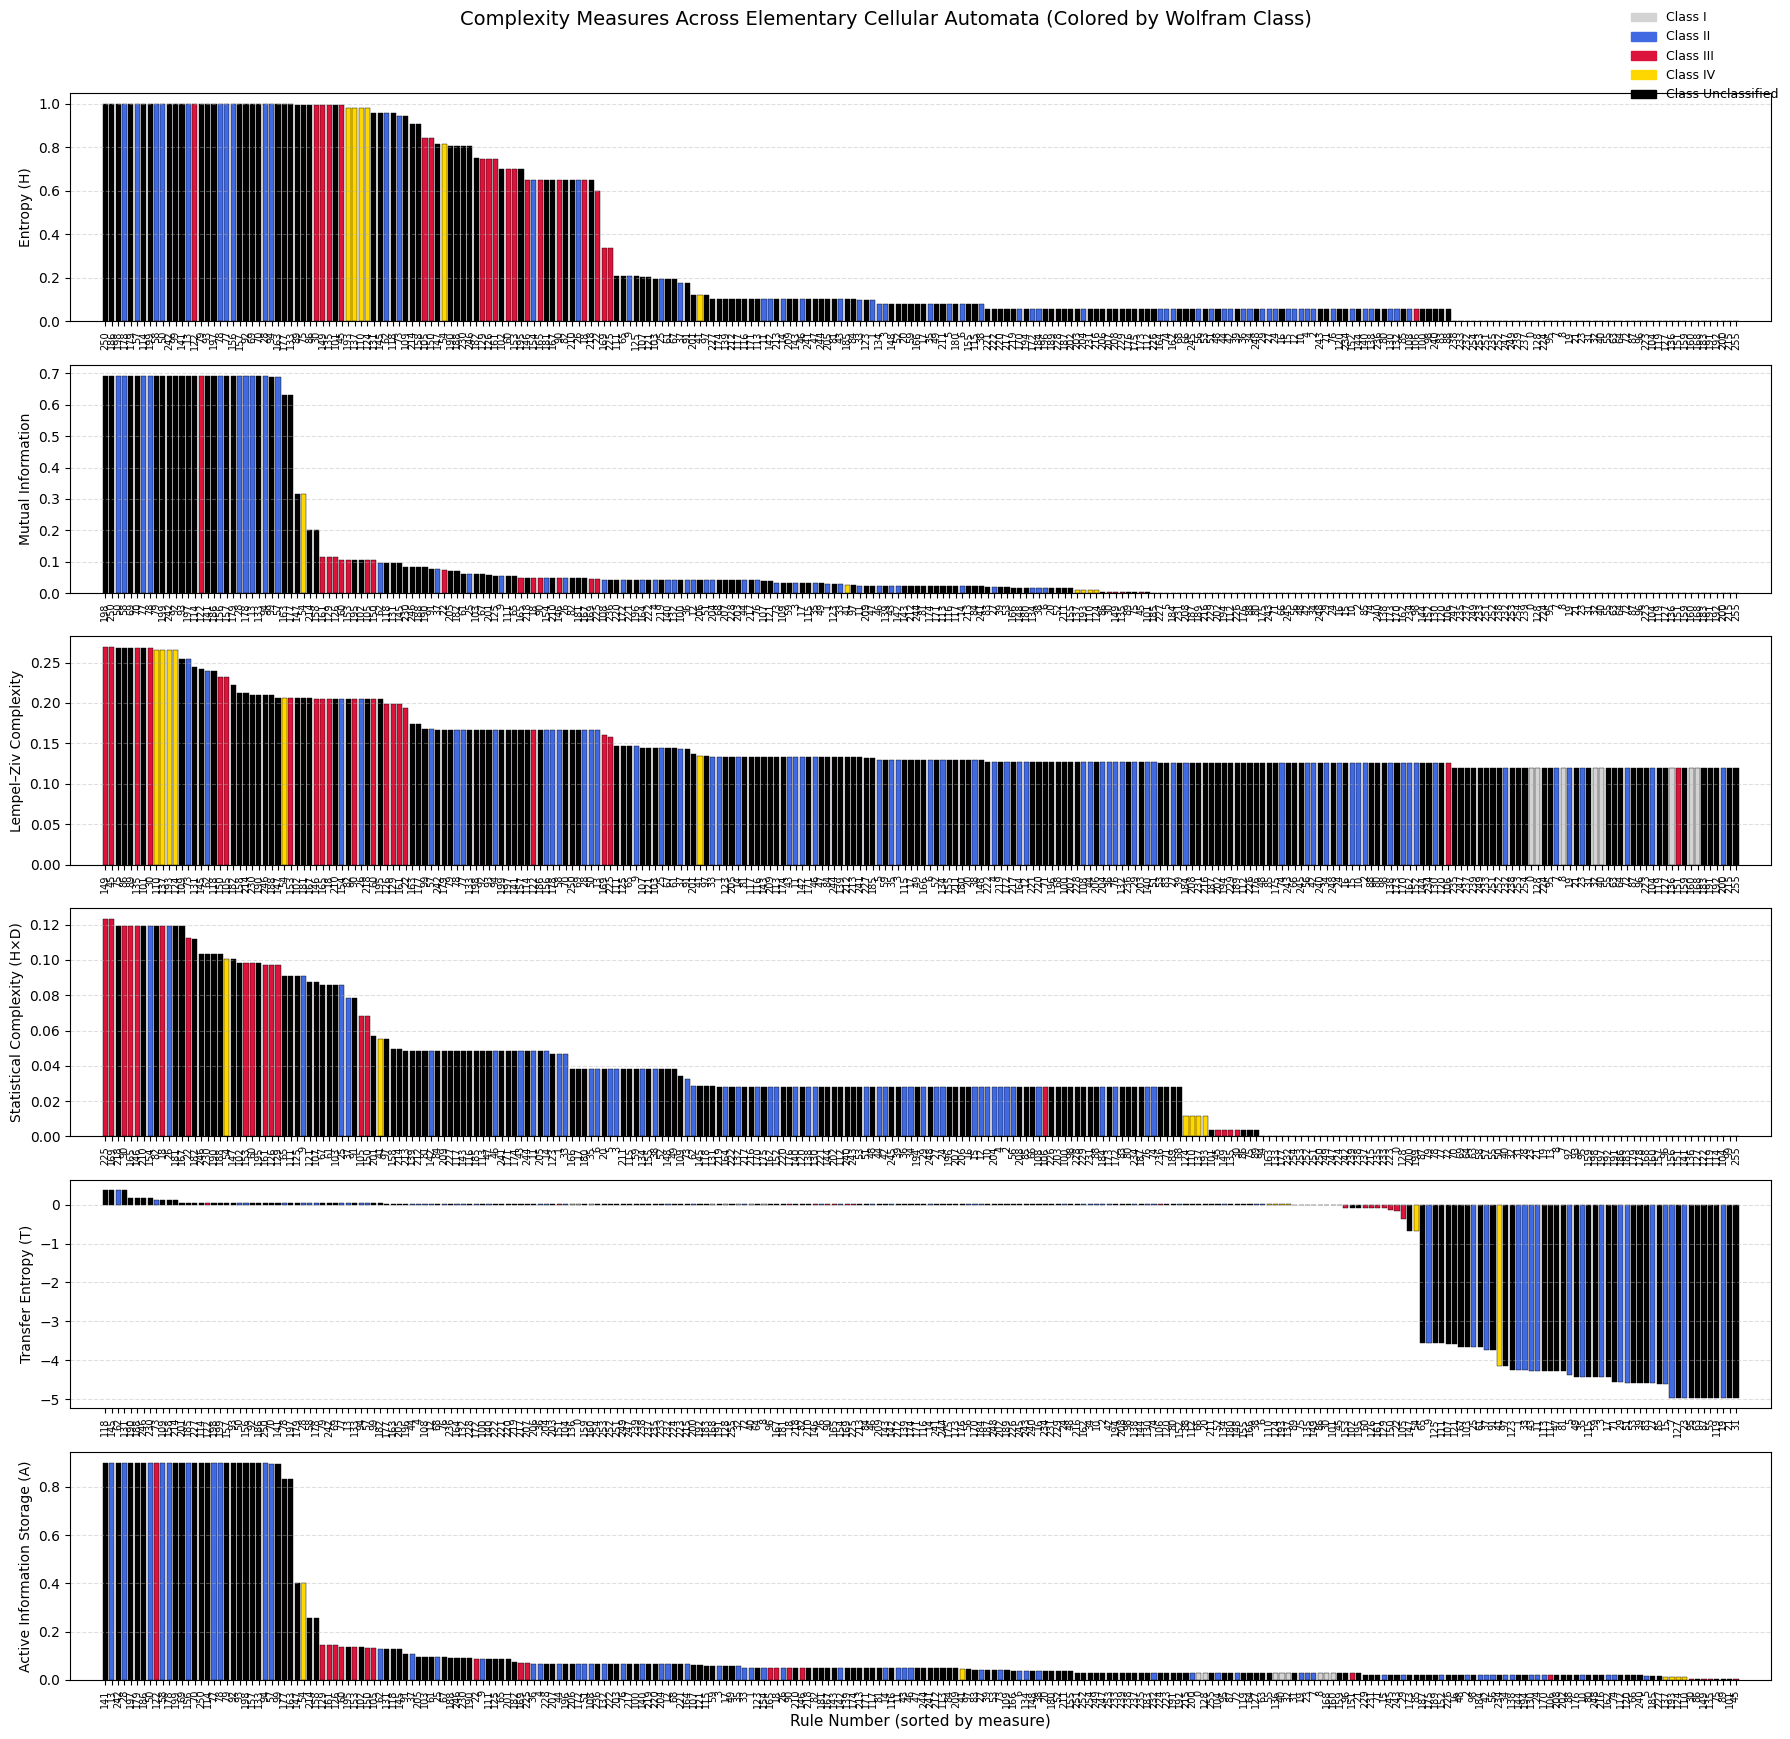

In [6]:
# --- Colors and classification ---
class_colors = {
    "I": "lightgray",      # Fixed
    "II": "royalblue",     # Periodic
    "III": "crimson",      # Chaotic
    "IV": "gold",          # Complex
    "Unclassified": "black"
}

def classify_rule(rule):
    for cls, rules in wolfram_classes.items():
        if rule in rules:
            return cls
    return "Unclassified"

# --- Analyze all rules (add Transfer Entropy) ---
results = []
for rule in range(256):
    ca = evolve_ca(rule, n_cells=150, n_steps=1000)[200:] #evolve ca and discard the first 200 steps

    ent = average_entropy(ca)
    mi = temporal_mutual_information(ca)
    lz = np.mean([lempel_ziv_complexity(row) for row in ca])
    sc = statistical_complexity(ca)
    te = transfer_entropy_between_states(ca)   # Transfer Entropy between states
    ai = active_information_storage(ca) #  Active Information Storage

    results.append([rule, ent, mi, lz, sc, te, ai, classify_rule(rule)])

df = pd.DataFrame(results, columns=["Rule", "Entropy", "MutualInfo", "LempelZiv", "StatComplexity", "TransferEntropy", "ActiveInfo", "Class"])

# --- Plot sorted bar charts for each measure ---
measures = [
    ("Entropy", "Entropy (H)"),
    ("MutualInfo", "Mutual Information"),
    ("LempelZiv", "Lempel–Ziv Complexity"),
    ("StatComplexity", "Statistical Complexity (H×D)"),
    ("TransferEntropy", "Transfer Entropy (T)"),
    ("ActiveInfo", "Active Information Storage (A)"),
]

fig, axs = plt.subplots(len(measures), 1, figsize=(18, 17))

for ax, (col, label) in zip(axs, measures):
    df_sorted = df.sort_values(by=col, ascending=False)
    colors = [class_colors[c] for c in df_sorted["Class"]]
    ax.bar(df_sorted["Rule"].astype(str), df_sorted[col], 
           color=colors, edgecolor="black", linewidth=0.3, width=0.8)
    ax.set_ylabel(label, fontsize=10)
    ax.set_xticks(range(len(df_sorted)))
    ax.set_xticklabels(df_sorted["Rule"].astype(str), rotation=90, fontsize=7, ha='center')
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.margins(x=0.02)  # more horizontal space to prevent overlap

axs[-1].set_xlabel("Rule Number (sorted by measure)", fontsize=11)

# --- Legend ---
handles = [plt.Rectangle((0,0),1,1,color=col) for col in class_colors.values()]
labels = [f"Class {k}" for k in class_colors.keys()]
fig.legend(handles, labels, loc="upper right", fontsize=9, frameon=False)

plt.suptitle("Complexity Measures Across Elementary Cellular Automata (Colored by Wolfram Class)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()